In [1]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from LogicalQ.Benchmarks import mirror_benchmarking, clifford_gates
from LogicalQ.NoiseModel import construct_noise_model
from LogicalQ.Logical import LogicalCircuit
import time

# Steane code parameters
n_logical = 2
n_physical_per_logical = 7
n_qubits = n_logical * n_physical_per_logical
circuit_length = 30  # adjust as needed
shots = 1e7

In [2]:
# Quantinuum H2-2 noise parameters
ERR_1Q = 7.30e-5
ERR_2Q = 1.29e-3
RD01 = 9.00e-4  # P(0|1)
RD10 = 1.80e-3  # P(1|0)
AMP_1Q = 0.54 * 7.30e-5

basis_gates_all = ["u", "rz", "rzz", "zz"]

In [3]:
mb_circ = mirror_benchmarking(
    n_qubits=n_qubits,
    circuit_length=circuit_length,
    measure=True
)

def run_mb(noise_model=None, shots=shots, qec_params=None):
    sim = AerSimulator(noise_model=noise_model)
    job = sim.run(mb_circ, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # fidelity = prob of all-zeros outcome
    return counts.get('0' * n_qubits, 0) / shots

# 1. Ideal

In [4]:
fidelities = []
runtimes = []

t0 = time.time()
circuit = run_mb(noise_model=None)
runtimes.append(time.time() - t0)

fidelities.append(circuit)
print(f"No QEC: {fidelities}")

No QEC: [1.0]


# 2. Depolarizing (1q) on Clifford gates

In [5]:
# Apply only single-qubit depolarizing errors to Clifford gates
noise2 = construct_noise_model(
    basis_gates=[gate.lower() for gate in clifford_gates],
    n_qubits=n_qubits,
    depolarizing_error_1q=ERR_1Q
)

t0 = time.time()
circuit = run_mb(noise_model=noise2)
runtimes.append(time.time() - t0)

fidelities.append(circuit)
print(f"No QEC: {fidelities}")

No QEC: [1.0, 0.9994898]


# 3. Depolarizing (1q) on all gates

In [6]:
noise3 = construct_noise_model(
    basis_gates=basis_gates_all,
    n_qubits=n_qubits,
    depolarizing_error_1q=ERR_1Q
)

t0 = time.time()
circuit = run_mb(noise_model=noise3)
runtimes.append(time.time() - t0)

fidelities.append(circuit)
print(f"No QEC: {fidelities}")

No QEC: [1.0, 0.9994898, 0.9994902]


# 4. Depolarizing (1q) + Depolarizing (2q) on all gates

In [7]:
noise4 = construct_noise_model(
    basis_gates=basis_gates_all,
    n_qubits=n_qubits,
    depolarizing_error_1q=ERR_1Q,
    depolarizing_error_2q=ERR_2Q
)

t0 = time.time()
circuit = run_mb(noise_model=noise4)
runtimes.append(time.time() - t0)

fidelities.append(circuit)
print(f"No QEC: {fidelities}")

No QEC: [1.0, 0.9994898, 0.9994902, 0.9841085]


# 5. + Amplitude damping 1q

In [8]:
noise5 = construct_noise_model(
    basis_gates=basis_gates_all,
    n_qubits=n_qubits,
    depolarizing_error_1q=ERR_1Q,
    depolarizing_error_2q=ERR_2Q,
    amplitude_damping_error_1q=AMP_1Q
)

t0 = time.time()
circuit = run_mb(noise_model=noise5)
runtimes.append(time.time() - t0)

fidelities.append(circuit)
print(f"No QEC: {fidelities}")

No QEC: [1.0, 0.9994898, 0.9994902, 0.9841085, 0.9838609]


# 6. + Readout errors

In [9]:
noise6 = construct_noise_model(
    basis_gates=basis_gates_all,
    n_qubits=n_qubits,
    depolarizing_error_1q=ERR_1Q,
    depolarizing_error_2q=ERR_2Q,
    **{"readout_error_0|1": RD01, "readout_error_1|0": RD10},
    amplitude_damping_error_1q=AMP_1Q
)

t0 = time.time()
circuit = run_mb(noise_model=noise6)
runtimes.append(time.time() - t0)

fidelities.append(circuit)
print(f"No QEC: {fidelities}")

No QEC: [1.0, 0.9994898, 0.9994902, 0.9841085, 0.9838609, 0.9838616]


# Summary Plot

In [10]:
import matplotlib.pyplot as plt
import numpy as np

scenarios    = ['Ideal', '1q Clifford', '1q All', '1q+2q', '1q+2q+Amp_1q', '1q+2q+Amp_1q+RO']
infidelities = [1 - f for f in fidelities]

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(scenarios, infidelities)

ax.set_xticklabels(scenarios, rotation=35, ha='center')
fig.tight_layout()   

# numeric labels
for x, y in zip(scenarios, infidelities):
    ax.text(x, y * 1.0, f"{y:.6f}", ha='center', va='bottom');


ax.set_yscale('log')
ax.set_title('Mirror Benchmarking Infidelity vs Noise Model (Without QEC)', pad=10)
ax.set_ylabel('Infidelity')

ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.9, alpha=0.8)
ax.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.6)

plt.show()

/var/folders/2g/30fq15_16yvcsfwpd5x9z9p80000gn/T/ipykernel_35656/3000064384.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scenarios, rotation=35, ha='center')


/var/folders/2g/30fq15_16yvcsfwpd5x9z9p80000gn/T/ipykernel_35656/2833672933.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(scenarios, rotation=35, ha='center')


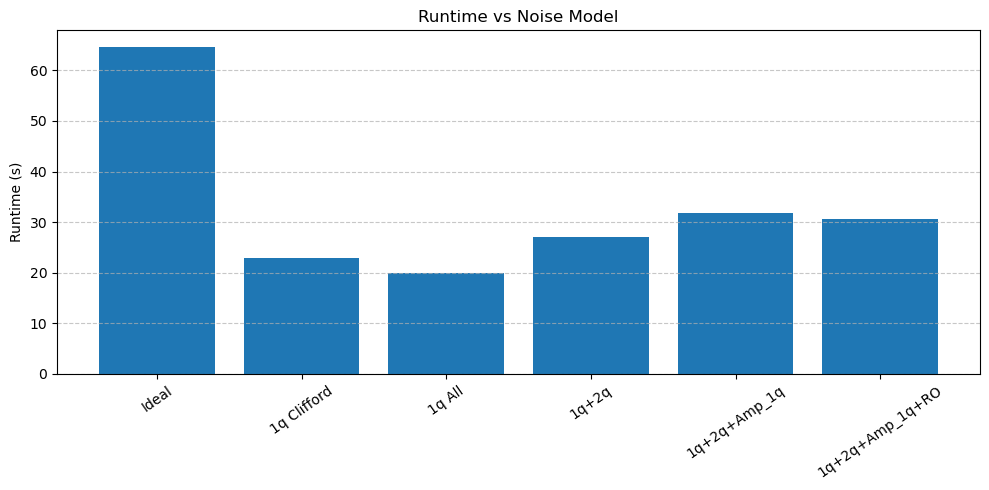

In [11]:
# Supplemental runtime bar chart
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.bar(scenarios, runtimes)
ax2.set_xticklabels(scenarios, rotation=35, ha='center')
ax2.set_ylabel('Runtime (s)')
ax2.set_title('Runtime vs Noise Model')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
fig2.tight_layout()
plt.show()